# control estimation of attraction coefficients
Tim Tyree<br>
10.26.2021

In [1]:
from lib.my_initialization import *
from lib import *
# from lib.measure.unwrap_and_smooth_cu import *
# from lib.rapids_func import *
# .routines.unwrap_and_smooth_trajectories_cu import *

import itertools
import dask_cudf
from lib.rapids_func import *
get_DT_cu

#magic    
%autocall 1
%load_ext autoreload
%autoreload 2

# import cupy as cp, cudf, numba.cuda as cuda
# import rmm
# # Switch to RMM allocator
# cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

Automatic calling is: Smart


In [2]:
print(f"The squared range method of estimating the attraction coefficient exhibited a bias smaller than {100*np.abs(5-4.99981674)/5:.3f}% for a known control.")

The squared range method of estimating the attraction coefficient exhibited a bias smaller than 0.004% for a known control.


- The massive dataset I created was not run long enough for the particles to get close enough to annihilate.
- A simple dataset of high quality is created here in approximately 32 milliseconds of runtime.

In [3]:
# # do any of the massive dataset's trials have an annihilation event? ...No.
# # input_fn='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/smoothed_annihilations_tavg1_4.0_tavg2_14.25_maxdtmax_0_maxRfin_0.2_mindur_15/pbc_particle_log8_log_smoothed_annihilations_denoised.csv'
# input_fn_lst=get_all_files_matching_pattern(input_fn,'.csv')
# len(input_fn_lst)
# max_numfiles=50
# input_fn_lst=input_fn_lst[:max_numfiles]
# final_time_lst=[]
# for fn in input_fn_lst:
#     df=pd.read_csv(input_fn_lst[i])
#     final_time=df.tail(1)['t'].values[0]
#     final_time_lst.append(final_time)
# print(f"the minimum final time is {np.min(final_time)} ms.")

# generating a simple, deterministic control trial
Consider two particles start r0=1 cm apart and are attracted to eachother at a speed of a/r, with a=5 cm^2/s, fixed.  We consider the same time step as in the simulations of the particle model, Dt=1e-5 seconds.  Due to the radial symmetry of the problem, we may asuume one dimensional motion, without loss of generality.  Due to the deterministic nature of the problem, a single trial achieves the same value for the mean range timeseries as multiple trials to machine precision.

__Conclusion__ 
- it makes more sense to use the squared range method to measure a.  
- the only remaining value of the inverse range method is to verify that an inverse powerlaw attractive force is reasonable to consider.

Let the range between two particles, $R(t)$ be described by the following ordinary differential equation:
$$
\frac{dR}{dt}=\frac{-2a}{R}
$$

Integrating up until the time the particles meet, $t_f$, we recover the solution
$$
R^2(t)=\frac{a}{4}(t_f-t)
$$

__Results__
- the squared range method is stable at close ranges while the inverse square method is not.
- compared to the inverse range until annihilation method, the squared range until annihilation method 
    - is more accurate and more precise, and
    - produced robust estimates of a known control independent of the choice of an additional parameter, $R_{min. thresh}$, for the minimum range to consider in the OLS regression.
- considering shorter ranges produced 
    - better resulting estimate for $a$ with the squared range method
    - better resulting estimate for $a$ with the inverse range method
    - better resulting $R^2$ with the squared range method
    - worse resulting $R^2$ with the inverse range method
    
__Summary__
- with and without the signal processing techniques (i, ii, iii), _the squared range method was both more precise and more accurate_ when compared to the inverse range method for a known control.
    - (i) restricting ranges under consideration to distances further than $R_{min.\; thresh}$
    - (ii) applying a savitzky-golay filtration of duration $\tau_{savgol}$ to $R(t)$
    - (iii) applying a moving average filtration of duration $\tau_{moving average}$ to the raw positional trajectories.
- the squared range method was insensitive to the signal processing techniques (i, ii, iii) for reasonable parameter choices, $R_{min.\; thresh}=0.5 cm$, $\tau_{savgol}=10 ms$, and $\tau_{moving average}=10 ms$ for a known control.

In [4]:
r0=1 #cm
rend=0.001 #cm
x1=0
x2=r0
a=5
Dt=1e-5
impulse_prefactor=Dt*a
print(f"impulse_prefactor=a*Dt={impulse_prefactor} cm^2")
R=x2-x1
R_lst=[]
while R>rend:
    F1=impulse_prefactor/R
    F2=-F1
    x1+=F1
    x2+=F2
    R=x2-x1
    R_lst.append(R)

impulse_prefactor=a*Dt=5e-05 cm^2


In [36]:
t_values=np.arange(0,Dt*len(R_lst),Dt)
R_values=np.array(R_lst)

t_values=np.max(t_values)-t_values
SR_values=R_values**2

one_over_R_values=2/(R_values[1:]+R_values[:-1])
dRdt_values=-(R_values[:-1]-R_values[1:])/Dt

In [37]:
R_thresh=0.5 #cm

#squared range method
boo=R_values>R_thresh
dict_sr=compute_slope.compute_95CI_ols(t_values[boo], SR_values[boo])
a_sr=dict_sr['m']/4
Delta_a_sr=dict_sr['Delta_m']/4

#inverse range method
boo=one_over_R_values<1/R_thresh
dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
a_one_over_R=-1*dict_one_over_R['m']/2
Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

print(f"the expected value of a is {5} cm^2/s.")
print(f"considering ranges exceeding {R_thresh} cm...")
print(f"the apparent value of a is {a_sr:.8f}+-{Delta_a_sr:.8f} cm^2/s (SR method).")
print(f"the apparent value of a is {a_one_over_R:.8f}+-{Delta_a_one_over_R:.8f} cm^2/s (1/R method).")

#predict
SR_hat_values=dict_sr['m']*t_values+dict_sr['b']
dRdt_hat_values=dict_one_over_R['m']*one_over_R_values+dict_one_over_R['b']

the expected value of a is 5 cm^2/s.
considering ranges exceeding 0.5 cm...
the apparent value of a is 4.99956562+-0.00000243 cm^2/s (SR method).
the apparent value of a is 4.99842722+-0.00000911 cm^2/s (1/R method).


In [38]:
print(f"The squared range method of estimating the attraction coefficient exhibited a bias smaller than {100*np.abs(5-4.99956562)/5:.4f}% for a known control.")

The squared range method of estimating the attraction coefficient exhibited a bias smaller than 0.0087% for a known control.


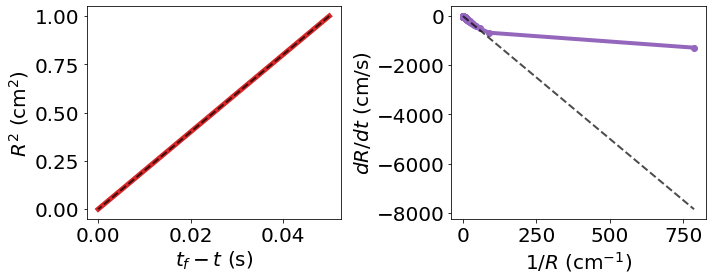

In [7]:
fig,axs=plt.subplots(ncols=2,figsize=(10,4))
ax=axs[0]
ax.plot(t_values,SR_values,c='C3',lw=5)
ax.plot(t_values,SR_hat_values,'k--',alpha=0.7,lw=2)
format_plot(ax=ax,xlabel=r'$t_f-t$ (s)',ylabel=r'$R^2$ (cm$^2$)')
ax=axs[1]
ax.scatter(one_over_R_values,dRdt_values,c='C4')
ax.plot(one_over_R_values,dRdt_values,c='C4',lw=4)
ax.plot(one_over_R_values,dRdt_hat_values,'k--',alpha=0.7,lw=2)
format_plot(ax=ax,xlabel=r'$1/R$ (cm$^{-1}$)',ylabel=r'$dR/dt$ (cm/s)')
plt.tight_layout()
plt.show()

# measure the value versus the minimum range threshold

In [8]:
#DONE: make ^this into a nice plot
#DONE: quantify the apparent a from the SR method
#DONE: plot 1/R versus dRdt
#DONE: quantify the apparent a from the 1/R method
#TODO: put ^those into a .odg file
#TODO: show how this varies with R_thresh
#TODO: apply a savitky golay filter, and plot the effect tavg2 versus a for either method

In [9]:
R_thresh_values=np.arange(1e-2,1,0.01)
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
a_one_over_R_lst=[]
Delta_a_one_over_R_lst=[]
Rsq_sr_lst=[]
Rsq_one_over_R_lst=[]
for R_thresh in R_thresh_values:
    #squared range method
    boo=R_values>R_thresh
    dict_sr=compute_slope.compute_95CI_ols(t_values[boo], SR_values[boo])
    a_sr=dict_sr['m']/4
    Delta_a_sr=dict_sr['Delta_m']/4

    #inverse range method
    boo=one_over_R_values<1/R_thresh
    dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
    a_one_over_R=-1*dict_one_over_R['m']/2
    Delta_a_one_over_R=dict_one_over_R['Delta_m']/2
    
    #record results
    a_sr_lst.append(a_sr)
    Delta_a_sr_lst.append(Delta_a_sr)
    a_one_over_R_lst.append(a_one_over_R)
    Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
    Rsq_sr_lst.append(dict_sr['Rsquared'])
    Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])

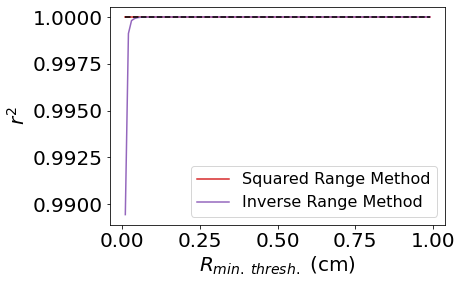

In [10]:
plt.plot(R_thresh_values,Rsq_sr_lst,'C3-',label='Squared Range Method')
plt.plot(R_thresh_values,Rsq_one_over_R_lst,'C4-',label='Inverse Range Method')
plt.plot(R_thresh_values,1+0.*R_thresh_values,'k--')#,label='Known Control')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel=r'$R_{min.\;thresh.}$ (cm)',ylabel=r'$r^2$')
plt.show()

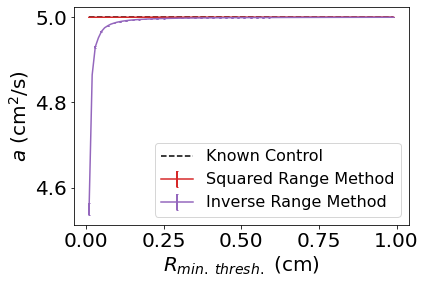

In [11]:
plt.errorbar(
    x=R_thresh_values,y=a_sr_lst,yerr=Delta_a_sr_lst,
    fmt='C3-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Squared Range Method')
plt.errorbar(
    x=R_thresh_values,y=a_one_over_R_lst,yerr=Delta_a_one_over_R_lst,
    fmt='C4-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Inverse Range Method')
plt.plot(R_thresh_values,5+0.*R_thresh_values,'k--',label='Known Control')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel=r'$R_{min.\;thresh.}$ (cm)',ylabel=r'$a$ (cm$^2$/s)')
plt.show()

In [12]:
da_sr_values=np.array(a_sr_lst)-5
da_one_over_R_values=np.array(a_one_over_R_lst)-5

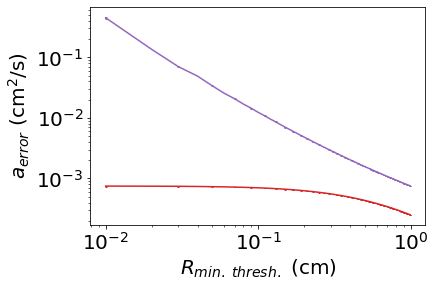

In [13]:
plt.errorbar(
    x=R_thresh_values,y=np.abs(da_sr_values),yerr=Delta_a_sr_lst,
    fmt='C3-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Squared Range Method')
plt.errorbar(
    x=R_thresh_values,y=np.abs(da_one_over_R_values),yerr=Delta_a_one_over_R_lst,
    fmt='C4-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Inverse Range Method')
# plt.legend(fontsize=12)
format_plot(ax=plt.gca(),xlabel=r'$R_{min.\;thresh.}$ (cm)',ylabel=r'$a_{error}$ (cm$^2$/s)', use_loglog=True)
plt.show()

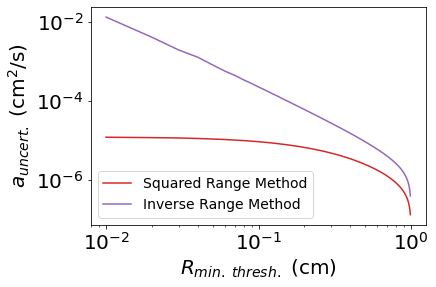

In [14]:
plt.plot(R_thresh_values,Delta_a_sr_lst,'C3-',label='Squared Range Method')
plt.plot(R_thresh_values,Delta_a_one_over_R_lst,'C4-',label='Inverse Range Method')
# plt.plot(R_thresh_values,1+0.*R_thresh_values,'k--')#,label='Known Control')
plt.legend(fontsize=14)
format_plot(ax=plt.gca(),xlabel=r'$R_{min.\;thresh.}$ (cm)',ylabel=r'$a_{uncert.}$ (cm$^2$/s)', use_loglog=True)
plt.show()

# quantify error due to taking savitzky golay filtration

- set R_thresh=0.5 cm fixed
- apply savgol filter of time window tavg2=window to R_values
- compute a_sr and Delta_sr on all data
- append to list
- visualize

then,
- collect all ^this into a .odg and share

In [15]:
R_thresh=0.5
tavg2=14 #ms
#compute a with R_savgol_values
navg2=int(tavg2//(Dt*1e3))
savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
#compute the savgol_filtered values for R
R_savgol_values=savgol_filter(R_values,**savgol_kwargs)
#compute xy values
SR_values=R_savgol_values**2
one_over_R_values=2/(R_savgol_values[1:]+R_savgol_values[:-1])
dRdt_values=-(R_savgol_values[:-1]-R_savgol_values[1:])/Dt

#squared range method
boo=R_values>R_thresh
dict_sr=compute_slope.compute_95CI_ols(t_values[boo], SR_values[boo])
a_sr=dict_sr['m']/4
Delta_a_sr=dict_sr['Delta_m']/4

#inverse range method
boo=one_over_R_values<1/R_thresh
dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
a_one_over_R=-1*dict_one_over_R['m']/2
Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

print(f"the expected value of a is {5} cm^2/s.")
print(f"considering ranges exceeding {R_thresh} cm...")
print(f"using a savgol time window of {tavg2} ms...")
print(f"the apparent value of a is {a_sr:.8f}+-{Delta_a_sr:.8f} cm^2/s (SR method).")
print(f"the apparent value of a is {a_one_over_R:.8f}+-{Delta_a_one_over_R:.8f} cm^2/s (1/R method).")

the expected value of a is 5 cm^2/s.
considering ranges exceeding 0.5 cm...
using a savgol time window of 14 ms...
the apparent value of a is 4.99883908+-0.00002068 cm^2/s (SR method).
the apparent value of a is 4.98371734+-0.00034607 cm^2/s (1/R method).


In [39]:
print(f"The squared range method of estimating the attraction coefficient exhibited a bias smaller than {100*np.abs(5-4.99883908)/5:.4f}% for a known control.")

The squared range method of estimating the attraction coefficient exhibited a bias smaller than 0.0232% for a known control.


In [16]:
R_thresh=0.5

In [17]:
#compute odd time value windows
navg2_values=np.arange(5,3000,2)
tavg2_values=np.around(navg2_values*Dt*1e3,7) #ms
tavg2_values

array([ 0.05,  0.07,  0.09, ..., 29.95, 29.97, 29.99])

In [18]:
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
a_one_over_R_lst=[]
Delta_a_one_over_R_lst=[]
Rsq_sr_lst=[]
Rsq_one_over_R_lst=[]
for navg2 in navg2_values:
    #compute a with R_savgol_values
    savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
    #compute the savgol_filtered values for R
    R_savgol_values=savgol_filter(R_values,**savgol_kwargs)
    
    #compute xy values
    SR_values=R_savgol_values**2
    one_over_R_values=2/(R_savgol_values[1:]+R_savgol_values[:-1])
    dRdt_values=-(R_savgol_values[:-1]-R_savgol_values[1:])/Dt

    #squared range method
    boo=R_values>R_thresh
    dict_sr=compute_slope.compute_95CI_ols(t_values[boo], SR_values[boo])
    a_sr=dict_sr['m']/4
    Delta_a_sr=dict_sr['Delta_m']/4

    #inverse range method
    boo=one_over_R_values<1/R_thresh
    dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
    a_one_over_R=-1*dict_one_over_R['m']/2
    Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

    #squared range method
    boo=R_values>R_thresh
    dict_sr=compute_slope.compute_95CI_ols(t_values[boo], SR_values[boo])
    a_sr=dict_sr['m']/4
    Delta_a_sr=dict_sr['Delta_m']/4

    #inverse range method
    boo=one_over_R_values<1/R_thresh
    dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
    a_one_over_R=-1*dict_one_over_R['m']/2
    Delta_a_one_over_R=dict_one_over_R['Delta_m']/2
    
    #record results
    a_sr_lst.append(a_sr)
    Delta_a_sr_lst.append(Delta_a_sr)
    a_one_over_R_lst.append(a_one_over_R)
    Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
    Rsq_sr_lst.append(dict_sr['Rsquared'])
    Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])

da_sr_values=np.array(a_sr_lst)-5
da_one_over_R_values=np.array(a_one_over_R_lst)-5

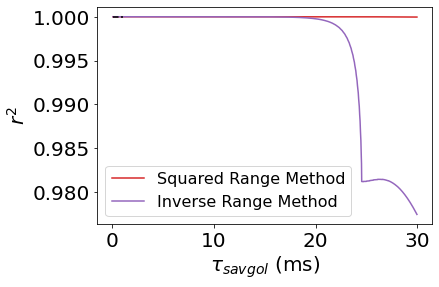

In [19]:
plt.plot(tavg2_values,Rsq_sr_lst,'C3-',label='Squared Range Method')
plt.plot(tavg2_values,Rsq_one_over_R_lst,'C4-',label='Inverse Range Method')
plt.plot(R_thresh_values,1+0.*R_thresh_values,'k--')#,label='Known Control')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{savgol}$ (ms)',ylabel=r'$r^2$')
plt.show()

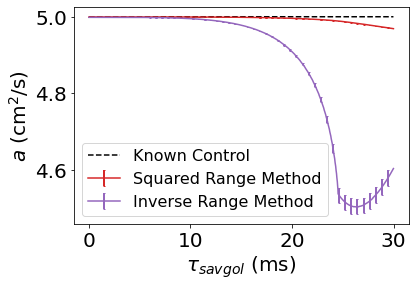

In [20]:
plt.errorbar(
    x=tavg2_values,y=a_sr_lst,yerr=Delta_a_sr_lst,
    fmt='C3-',ecolor=None,elinewidth=2,capsize=1,errorevery=30,capthick=None,label='Squared Range Method')
plt.errorbar(
    x=tavg2_values,y=a_one_over_R_lst,yerr=Delta_a_one_over_R_lst,
    fmt='C4-',ecolor=None,elinewidth=2,capsize=1,errorevery=30,capthick=None,label='Inverse Range Method')
plt.plot(tavg2_values,5+0.*tavg2_values,'k--',label='Known Control')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{savgol}$ (ms)',ylabel=r'$a$ (cm$^2$/s)')
plt.show()

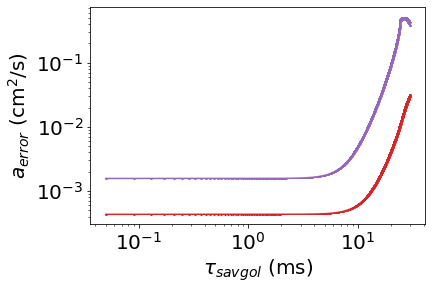

In [21]:
plt.errorbar(
    x=tavg2_values,y=np.abs(da_sr_values),yerr=Delta_a_sr_lst,
    fmt='C3-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Squared Range Method')
plt.errorbar(
    x=tavg2_values,y=np.abs(da_one_over_R_values),yerr=Delta_a_one_over_R_lst,
    fmt='C4-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Inverse Range Method')
# plt.legend(fontsize=12)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{savgol}$ (ms)',ylabel=r'$a_{error}$ (cm$^2$/s)', use_loglog=True)
plt.show()

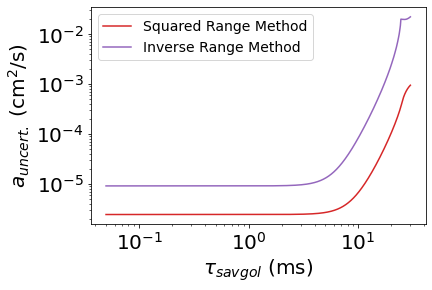

In [22]:
plt.plot(tavg2_values,Delta_a_sr_lst,'C3-',label='Squared Range Method')
plt.plot(tavg2_values,Delta_a_one_over_R_lst,'C4-',label='Inverse Range Method')
# plt.plot(R_thresh_values,1+0.*R_thresh_values,'k--')#,label='Known Control')
plt.legend(fontsize=14)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{savgol}$ (ms)',ylabel=r'$a_{uncert.}$ (cm$^2$/s)', use_loglog=True)
plt.show()

# quantify error due to taking moving average
- TODO(later): show plots for three different values for tavg2... low, medium, and high.

In [23]:
#Note: since we reduced to one spatial dimension, the moving average may be applied directly to R_values
navg1=5
#compute odd time value windows
navg1_values=np.arange(5,3000,2)
tavg1_values=np.around(navg2_values*Dt*1e3,7) #ms

In [24]:
R_thresh=0.5
tavg1=7 #ms
navg1=int(tavg1//(Dt*1e3))
tavg2=14 #ms
navg2=int(tavg2//(Dt*1e3))
#compute a with R_savgol_values
savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
#compute the moving average of the positional trajectories
Ravg_values=moving_average(R_values,navg1)
tavg_values=moving_average(t_values,navg1)
#compute the savgol_filtered values for R
R_savgol_values=savgol_filter(Ravg_values,**savgol_kwargs)
#compute xy values
SR_values=R_savgol_values**2
one_over_R_values=2/(R_savgol_values[1:]+R_savgol_values[:-1])
dRdt_values=-(R_savgol_values[:-1]-R_savgol_values[1:])/Dt

#squared range method
boo=R_savgol_values>R_thresh
dict_sr=compute_slope.compute_95CI_ols(tavg_values[boo], SR_values[boo])
a_sr=dict_sr['m']/4
Delta_a_sr=dict_sr['Delta_m']/4

#inverse range method
boo=one_over_R_values<1/R_thresh
dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
a_one_over_R=-1*dict_one_over_R['m']/2
Delta_a_one_over_R=dict_one_over_R['Delta_m']/2

print(f"the expected value of a is {5} cm^2/s.")
print(f"using a moving average time window of {tavg1} ms...")
print(f"using a savgol time window of {tavg2} ms...")
print(f"considering ranges exceeding {R_thresh} cm...")
print(f"the apparent value of a is {a_sr:.8f}+-{Delta_a_sr:.8f} cm^2/s (SR method).")
print(f"the apparent value of a is {a_one_over_R:.8f}+-{Delta_a_one_over_R:.8f} cm^2/s (1/R method).")

the expected value of a is 5 cm^2/s.
using a moving average time window of 7 ms...
using a savgol time window of 14 ms...
considering ranges exceeding 0.5 cm...
the apparent value of a is 5.00598113+-0.00005974 cm^2/s (SR method).
the apparent value of a is 5.02885808+-0.00023132 cm^2/s (1/R method).


In [40]:
print(f"The squared range method of estimating the attraction coefficient exhibited a bias smaller than {100*np.abs(5-5.00598113)/5:.4f}% for a known control.")

The squared range method of estimating the attraction coefficient exhibited a bias smaller than 0.1196% for a known control.


In [25]:
#generate apparent attraction coefficient data
a_sr_lst=[]
Delta_a_sr_lst=[]
a_one_over_R_lst=[]
Delta_a_one_over_R_lst=[]
Rsq_sr_lst=[]
Rsq_one_over_R_lst=[]
for navg1 in navg1_values:
    #compute a with R_savgol_values
    savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
    #compute the moving average of the positional trajectories
    Ravg_values=moving_average(R_values,navg1)
    tavg_values=moving_average(t_values,navg1)
    #compute the savgol_filtered values for R
    R_savgol_values=savgol_filter(Ravg_values,**savgol_kwargs)
    
    #compute xy values
    SR_values=R_savgol_values**2
    one_over_R_values=2/(R_savgol_values[1:]+R_savgol_values[:-1])
    dRdt_values=-(R_savgol_values[:-1]-R_savgol_values[1:])/Dt

    #squared range method
    boo=Ravg_values>R_thresh
    dict_sr=compute_slope.compute_95CI_ols(tavg_values[boo], SR_values[boo])
    a_sr=dict_sr['m']/4
    Delta_a_sr=dict_sr['Delta_m']/4

    #inverse range method
    boo=one_over_R_values<1/R_thresh
    dict_one_over_R=compute_slope.compute_95CI_ols(one_over_R_values[boo], dRdt_values[boo])
    a_one_over_R=-1*dict_one_over_R['m']/2
    Delta_a_one_over_R=dict_one_over_R['Delta_m']/2
    
    #record results
    a_sr_lst.append(a_sr)
    Delta_a_sr_lst.append(Delta_a_sr)
    a_one_over_R_lst.append(a_one_over_R)
    Delta_a_one_over_R_lst.append(Delta_a_one_over_R)
    Rsq_sr_lst.append(dict_sr['Rsquared'])
    Rsq_one_over_R_lst.append(dict_one_over_R['Rsquared'])

da_sr_values=np.array(a_sr_lst)-5
da_one_over_R_values=np.array(a_one_over_R_lst)-5

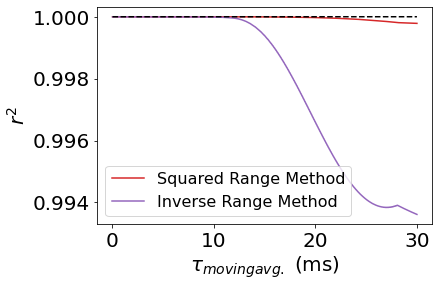

In [26]:
plt.plot(tavg1_values,Rsq_sr_lst,'C3-',label='Squared Range Method')
plt.plot(tavg1_values,Rsq_one_over_R_lst,'C4-',label='Inverse Range Method')
plt.plot(tavg1_values,1+0.*tavg1_values,'k--')#,label='Known Control')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{moving avg.}$ (ms)',ylabel=r'$r^2$')
plt.show()

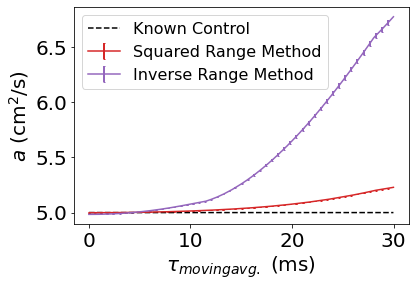

In [27]:
plt.errorbar(
    x=tavg1_values,y=a_sr_lst,yerr=Delta_a_sr_lst,
    fmt='C3-',ecolor=None,elinewidth=2,capsize=1,errorevery=30,capthick=None,label='Squared Range Method')
plt.errorbar(
    x=tavg1_values,y=a_one_over_R_lst,yerr=Delta_a_one_over_R_lst,
    fmt='C4-',ecolor=None,elinewidth=2,capsize=1,errorevery=30,capthick=None,label='Inverse Range Method')
plt.plot(tavg1_values,5+0.*tavg1_values,'k--',label='Known Control')
plt.legend(fontsize=16)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{moving avg.}$ (ms)',ylabel=r'$a$ (cm$^2$/s)')
plt.show()

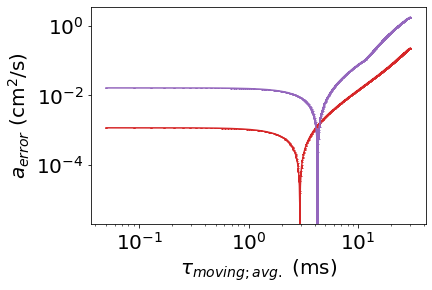

In [28]:
plt.errorbar(
    x=tavg1_values,y=np.abs(da_sr_values),yerr=Delta_a_sr_lst,
    fmt='C3-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Squared Range Method')
plt.errorbar(
    x=tavg1_values,y=np.abs(da_one_over_R_values),yerr=Delta_a_one_over_R_lst,
    fmt='C4-',ecolor=None,elinewidth=2,capsize=1,errorevery=2,capthick=None,label='Inverse Range Method')
# plt.legend(fontsize=12)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{moving;avg.}$ (ms)',ylabel=r'$a_{error}$ (cm$^2$/s)', use_loglog=True)
plt.show()

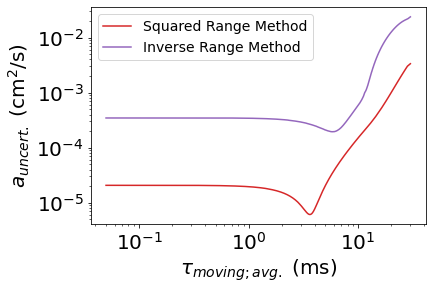

In [29]:
plt.plot(tavg1_values,Delta_a_sr_lst,'C3-',label='Squared Range Method')
plt.plot(tavg1_values,Delta_a_one_over_R_lst,'C4-',label='Inverse Range Method')
# plt.plot(R_thresh_values,1+0.*R_thresh_values,'k--')#,label='Known Control')
plt.legend(fontsize=14)
format_plot(ax=plt.gca(),xlabel=r'$\tau_{moving;avg.}$ (ms)',ylabel=r'$a_{uncert.}$ (cm$^2$/s)', use_loglog=True)
plt.show()

# computational check: finite difference deriv. of savgol filter is approximately the deriv. from the savgol filter

In [44]:
#DONE: test whether there is a significant difference between the savgol derivative and the finite difference derivative of the savgol filter
savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
#compute the moving average of the positional trajectories
Ravg_values=moving_average(R_values,navg1)
tavg_values=moving_average(t_values,navg1)
#compute the savgol_filtered values for R
R_savgol_values=savgol_filter(Ravg_values,**savgol_kwargs)
dRdt_values=-(R_savgol_values[:-1]-R_savgol_values[1:])/Dt

In [45]:
savgol_kwargs = dict(window_length=navg2,polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')
#compute the moving average of the positional trajectories
Ravg_values=moving_average(R_values,navg1)
tavg_values=moving_average(t_values,navg1)
#compute the savgol_filtered values for R
dRdt_savgol_values=savgol_filter(Ravg_values,**savgol_kwargs)*1e5
err_dRdt_values=np.abs(dRdt_values-dRdt_savgol_values[1:])

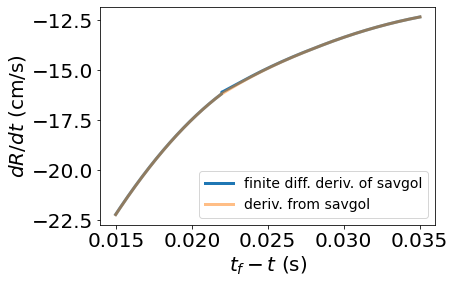

In [46]:
plt.plot(tavg_values[1:],dRdt_values, label='finite diff. deriv. of savgol',lw=3)
plt.plot(tavg_values,dRdt_savgol_values, alpha=0.5, label='deriv. from savgol',lw=3)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (s)',ylabel=r'$dR/dt$ (cm/s)')
plt.legend(fontsize=14)
plt.show()

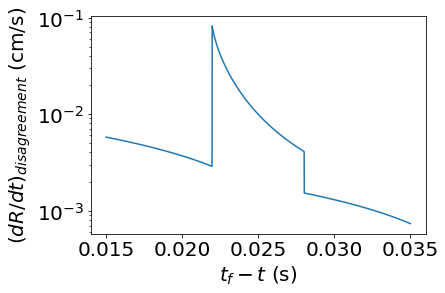

In [47]:
plt.plot(tavg_values[1:],err_dRdt_values)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (s)',ylabel=r'$(dR/dt)_{disagreement}$ (cm/s)')#,use_loglog=True)
plt.yscale('log')

plt.show()